Используйте базу трафика с сайта компании.

Напишите модель для прогнозирования трафика.

При параметре `length = 60`, добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

### Импорты

In [ ]:
# Работа с файловой системой
import os

# Отключение предупреждений
import warnings

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Вывод данных в Jupyter Notebook
from IPython.display import display

# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams

# Нормировщики
from sklearn.preprocessing import MinMaxScaler

# Коллбэк
# Основные слои
from tensorflow.keras.layers import (
    LSTM,
    Conv1D,
    Dense,
    Input,
    MaxPooling1D,
)

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Отрисовка графики в ячейке colab
%matplotlib inline

### Предварительные настройки

In [ ]:
# Отключение предупреждений
warnings.filterwarnings("ignore")
plt.style.use("ggplot")  # Использование стиля ggplot для графиков
rcParams["figure.figsize"] = (14, 7)  # Размер графиков по умолчанию

### Загрузка и чтение датасета

In [ ]:
if not os.path.exists("traff.csv"):
    #Загружаем базу трафика с сайта компании
    gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/traff.csv', None, quiet=True)

'traff.csv'

In [4]:
# ваше решение
data = pd.read_csv("traff.csv", header=None, thousands=",")

In [ ]:
display(data)

,0,1
0,1/1/2017,22226.0
1,1/2/2017,29593.0
2,1/3/2017,31726.0
3,1/4/2017,32684.0
4,1/5/2017,31820.0
...,...,...
1090,12/27/2019,29801.0
1091,12/28/2019,34913.0
1092,12/29/2019,37665.0
1093,12/30/2019,32643.0


### Обработка данных

In [ ]:
data = np.array(data[1]) # Преобразуем в массив numpy

In [ ]:
data = data.reshape(-1, 1) # Преобразуем в двумерный массив

SEQ_LEN = 50 # Длина последовательности
test_len = 300 # Длина тестовой выборки
train_len = data.shape[0] - test_len # Длина обучающей выборки

# Разделяем данные на обучающую и тестовую выборки
data_train, data_test = data[:train_len], data[train_len + 2 * SEQ_LEN :]

# Нормализуем данные с помощью MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

# Создаем генераторы временных рядов для обучения, валидации и тестирования
train_gen = TimeseriesGenerator(
    data_train, data_train, length=SEQ_LEN, stride=1, sampling_rate=1, batch_size=16
)
val_gen = TimeseriesGenerator(
    data_test, data_test, length=SEQ_LEN, stride=1, sampling_rate=1, batch_size=16
)
test_gen = TimeseriesGenerator(
    data_test,
    data_test,
    length=SEQ_LEN,
    stride=1,
    sampling_rate=1,
    batch_size=data_test.shape[0],
)

x_test, y_test = test_gen[0] # Получаем тестовые данные

print(f"Train batch x: {train_gen[0][0].shape}, y: {train_gen[0][1].shape}")

print(f"Test x: {x_test.shape}, y: {y_test.shape}")

Train batch x: (16, 50, 1), y: (16, 1)
Test x: (150, 50, 1), y: (150, 1)


### Функции для обучения и оценки модели

In [8]:
def get_pred(
    model,  # модель
    x_test,
    y_test,  # тестовая выборка
    y_scaler,
):  # масштабирующий объект для y
    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled


In [9]:
def show_predict(
    y_pred,
    y_true,  # прогноз данных и исходный ряд
    start,  # точка ряда, с которой начинается отрисовка графика
    length,  # количество точек для отрисовки графика
    chn_list=None,  # список каналов данных для отрисовки (по умолчанию все)
    chn_names=["Close"],  # список имен каналов данных
    title="",
):
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))
    if len(chn_list) != len(chn_names):
        chn_names = chn_list

    for chn in chn_list:
        plt.plot(y_pred[start : start + length, chn], label=f"{chn_names[chn]} Прогноз")
        plt.plot(y_true[start : start + length, chn], label=f"{chn_names[chn]} Базовый")

    plt.title(title)
    plt.xlabel("Время")
    plt.ylabel("Данные")
    plt.legend()
    plt.show()


In [10]:
def eval_net(
    model,  # модель
    x_test,
    y_test,  # тестовая выборка
    y_scaler,  # нормировщик выхода
    start=0,
    length=500,
    back_steps_max=30,  # параметры отображения графиков
    title="",
):
    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    print(y_pred.shape, " - pred")
    print(y_true.shape, " - true")

    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    show_predict(
        y_pred[1:],
        y_true[:-1],
        start,
        length,
        title=f"{title}: Сопоставление базового и прогнозного рядов",
    )


In [11]:
def train_eval_net(
    model,  # модель
    train_datagen,
    val_datagen,  # генераторы обучающей и проверочной выборок
    epoch_list,  # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
    x_test,
    y_test,
    y_scaler,
    start=0,
    length=500,
    back_steps_max=30,
    title="",
):
    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss="mse", optimizer=opt)
        # Фаза обучения модели
        print(f"Обучение {epochs} эпох")
        history = model.fit(
            train_datagen, epochs=epochs, validation_data=val_datagen, verbose=1
        )

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history["loss"], label="Ошибка на обучающем наборе")
        plt.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
        plt.title(f"{title}: График прогресса обучения")
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel("Эпоха обучения")
        plt.ylabel("Средняя ошибка")
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(
            model,
            x_test,
            y_test,
            y_scaler,
            start=start,
            length=length,
            back_steps_max=back_steps_max,
            title=title,
        )


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 50, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 150)            │         9,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,271 (262.78 KB)

 Trainable params: 67,271 (262.78 KB)

 Non-trainable params: 0 (0.00 B)

Обучение 50 эпох
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0656 - val_loss: 0.0195
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0137
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0170
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0138
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0088 - val_loss: 0.0124
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0117
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0115
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0128
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0115
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0112
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0170
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

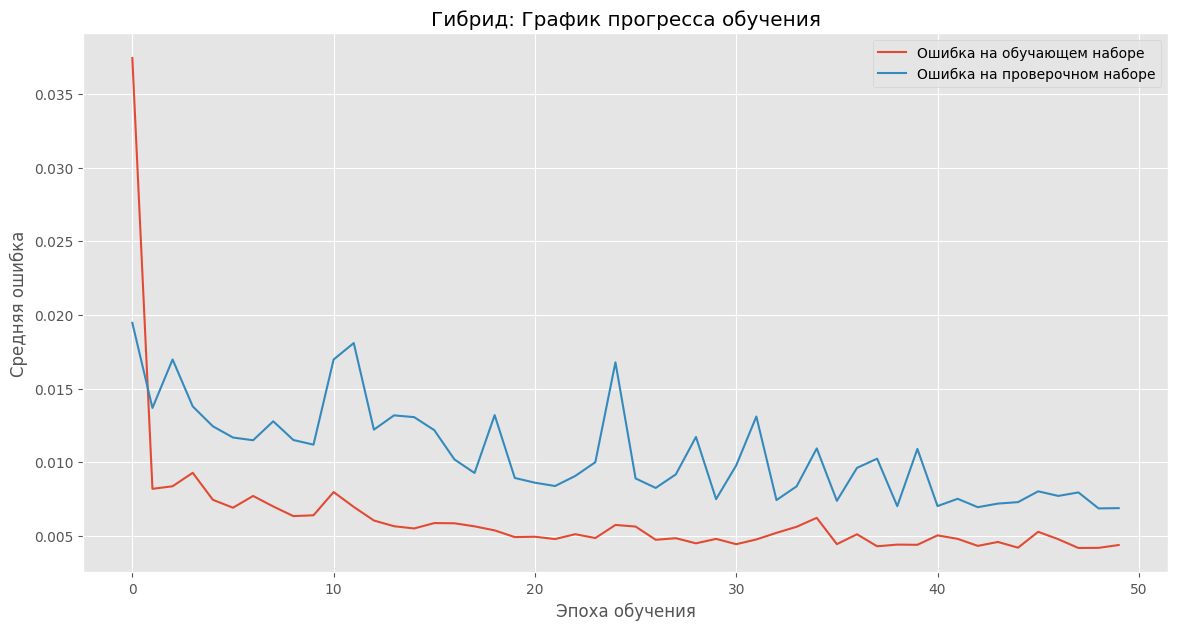

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
(150, 1)  - pred
(150, 1)  - true


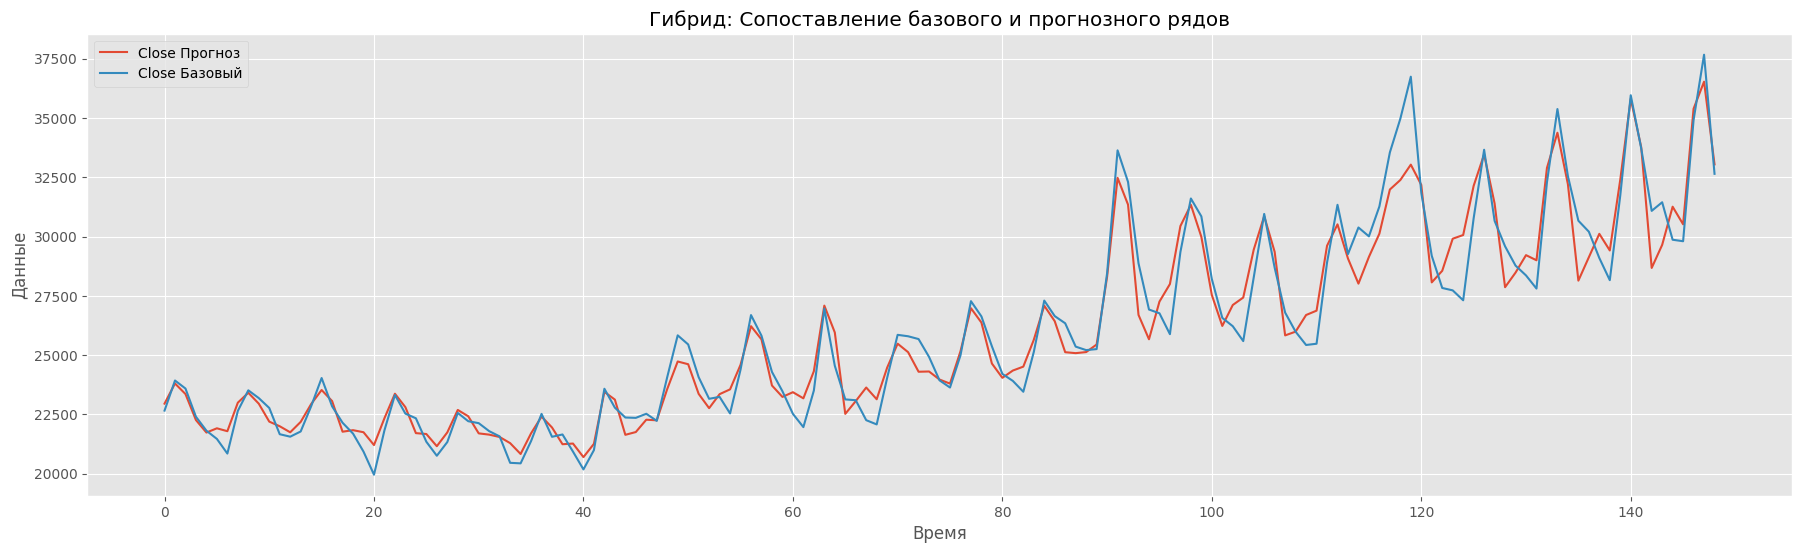

Обучение 50 эпох
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0039 - val_loss: 0.0074
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0069
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0082
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0071
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0074
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0073
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0070
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0071
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0085
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0072
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

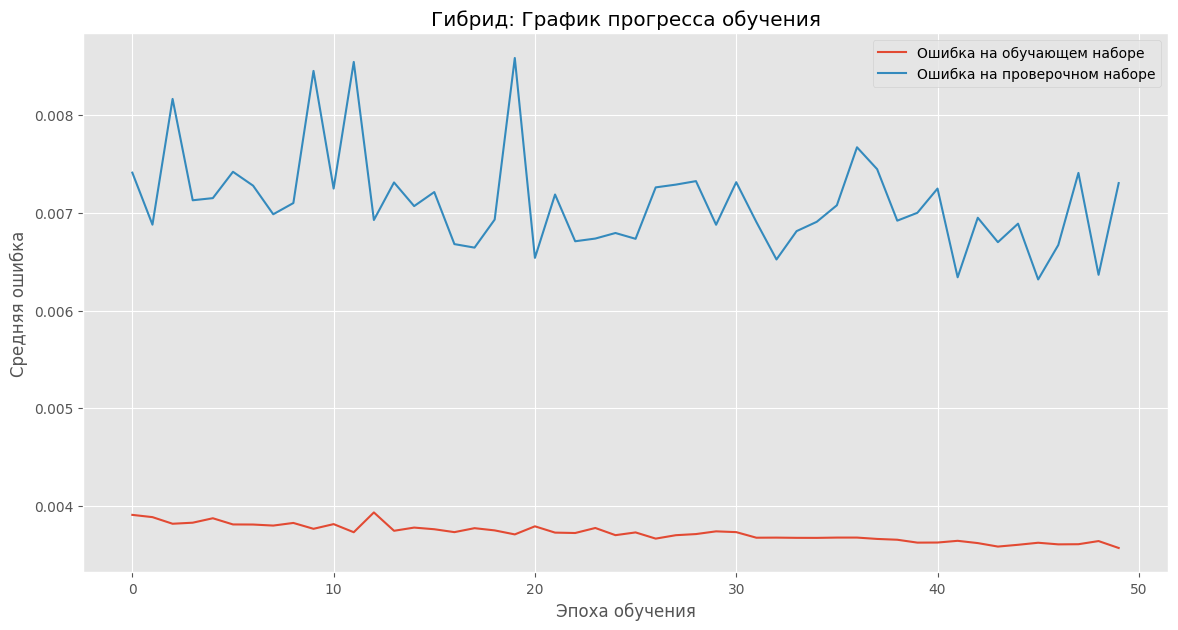

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
(150, 1)  - pred
(150, 1)  - true


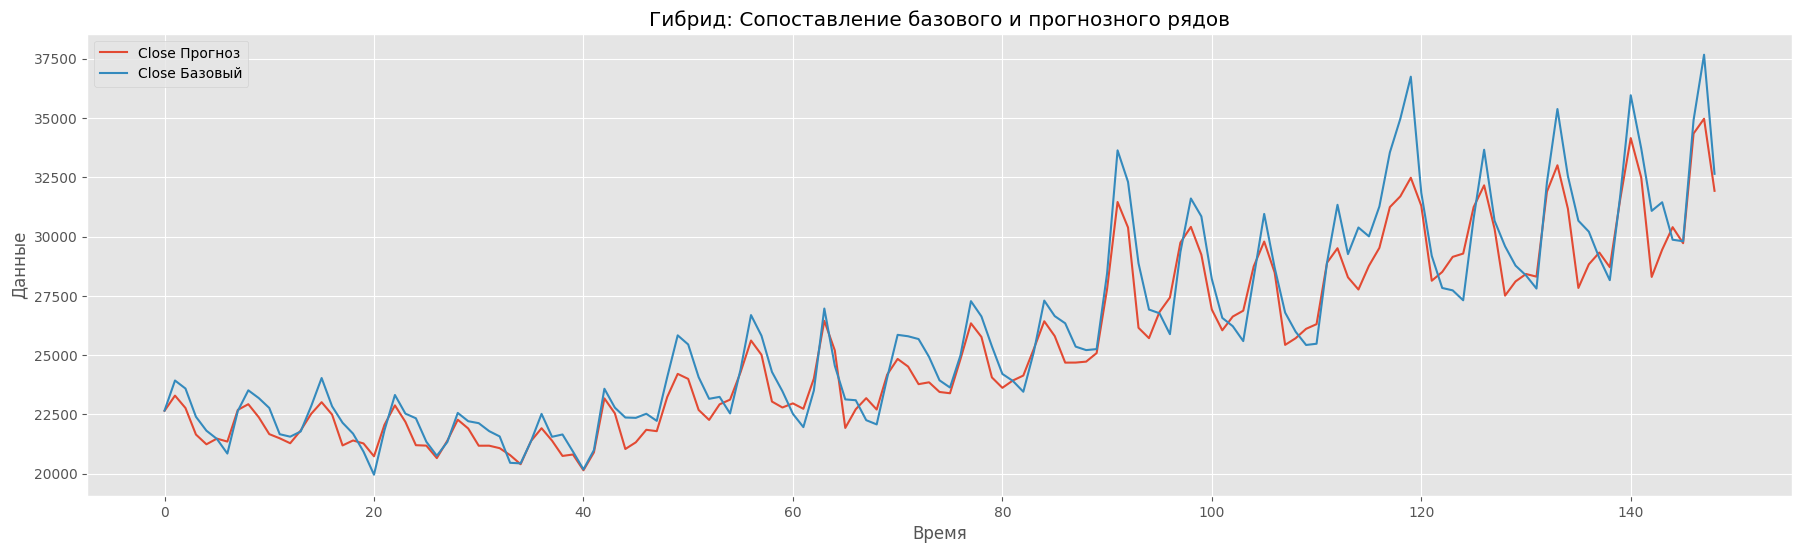

Обучение 50 эпох
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0035 - val_loss: 0.0067
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - val_loss: 0.0067
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0066
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0066
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0066
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0066
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0066
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0066
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0067
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

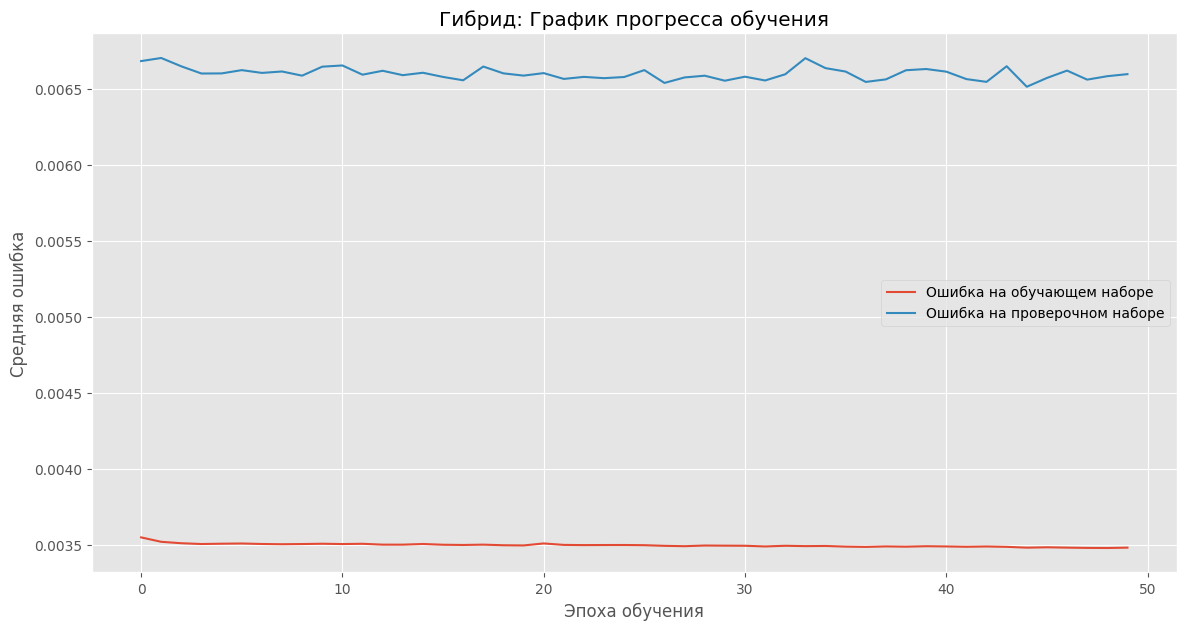

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
(150, 1)  - pred
(150, 1)  - true


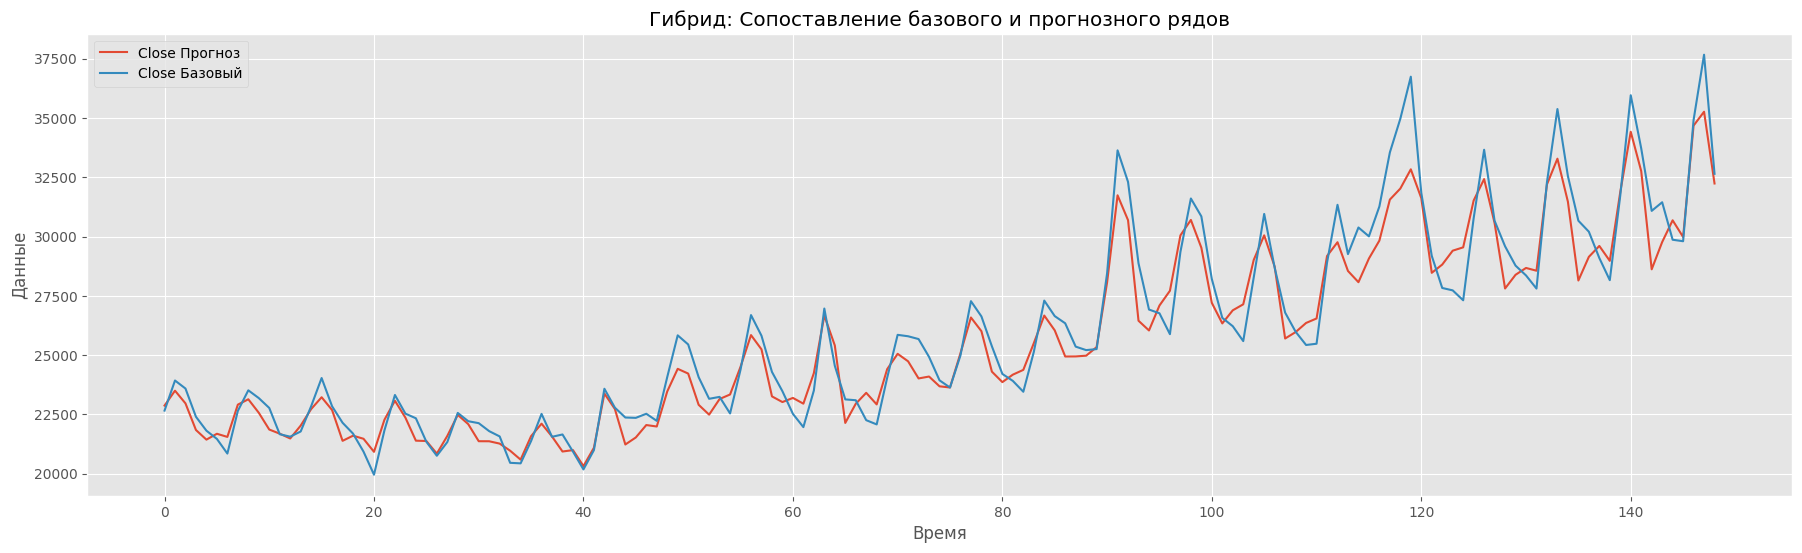

In [ ]:
model_hybrid = Sequential(
    [
        Input(shape=x_test.shape[1:]),
        Conv1D(128, 3, activation="relu", padding="causal"),
        MaxPooling1D(pool_size=2),
        LSTM(64, activation="relu", return_sequences=False),
        Dense(150, activation="relu"),
        Dense(50, activation="relu"),
        Dense(y_test.shape[1], activation="linear"),
    ]
) # Создание модели гибридной сети
train_eval_net(
    model_hybrid,
    train_gen,
    val_gen,
    [
        (50, Adam(learning_rate=1e-3)),
        (50, Adam(learning_rate=1e-4)),
        (50, Adam(learning_rate=1e-5)),
    ],
    x_test,
    y_test,
    scaler,
    title="Гибрид",
)
